In [1]:
import numpy as np
from scipy.special import gammaln
import random
from collections import Counter
import pickle
import matplotlib.pyplot as plt
import pydot
import itertools
import string

## hLDA-nCRP code 

In [4]:
def CRP(topic, gamma):

    crp_p = np.zeros(len(topic)+1)
    M = 0
    for i in range(len(topic)):
        M += len(topic[i])
        
    for i in range(len(topic)+1):
        if i == 0:
            crp_p[i] = gamma / (gamma + M) 
        else:
            crp_p[i] = len(topic[i-1])/(gamma + M)
    return crp_p

In [5]:
def topic_sampling(corpus, gamma):
    topic = []
    flat_words = list(itertools.chain.from_iterable(corpus))
    i = 0
    while i < len(flat_words):
        cm_prop = CRP(topic, gamma)/sum(CRP(topic, gamma))
        theta = np.random.multinomial(1,cm_prop).argmax()
        topic.append([flat_words[i]]) if theta == 0 else topic[theta-1].append(flat_words[i])
        i+=1
    return topic

In [6]:
def Z(corpus, T, alpha, beta):
   
    D = len(corpus)

    num_vocab = 0
    for i in range(D):
        num_vocab += len(corpus[i])
    z_topic=[[] for t in range(T)]
    z_doc=[[] for t in range(T)]
    dict = [[key,i] for i,c in enumerate(corpus) for j, key in enumerate(c)]  
    
    for e in dict:
        wi,i,j,p = e[0],e[1],0,np.zeros(T) 
        while j < T:
            lik=(z_topic[j].count(wi)+beta)/(len(z_topic[j]) +num_vocab*beta)
            pri=(np.sum(np.isin(z_topic[j],corpus[i]))+alpha)/(len(corpus[i]) +T*alpha)
            p[j]=lik * pri 
            j += 1
        i_top = np.random.multinomial(1, p/np.sum(p)).argmax()
        z_topic[i_top].append(wi)
        z_doc[i_top].append(i)
    
    return list(filter(None, z_topic)), list(filter(None, z_doc))

In [7]:
def CRP_prior(corpus, doc_topic, gamma):

    doc_p = np.zeros((len(corpus), len(doc_topic)))
    for i in range(len(corpus)):
        doc = []
        for j in range(len(doc_topic)):
            doc_num = [num for num in doc_topic[j]]
            doc.append(doc_num)
        doc_p[i,:] = CRP(doc, gamma)[1:]
    return doc_p

In [8]:
def word_likelihood(corpus, topic, eta):
    
    wm = np.zeros((len(corpus), len(topic)))
    
    W = 0
    for i in range(len(corpus)):
        W += len(corpus[i])
    
    for i in range(len(corpus)):
        doc = corpus[i]
        for j in range(len(topic)):
            l = topic[j]
            denom_1 = 1
            num_2 = 1
            
            n_cml_m = len(l) - len([w for w in set(doc) if w in l])
            num_1 = gammaln(n_cml_m + W * eta)
            denom_2 = gammaln(len(l) + W * eta)
            
            for word in doc:
                nw_cml_m = l.count(word) - doc.count(word)
                if nw_cml_m <= 0:
                    nw_cml_m = 0
                
                denom_1 += gammaln(nw_cml_m + eta)
                num_2 += gammaln(l.count(word) + eta)
            
            wm[i,j] = num_1 + num_2 - denom_1 - denom_2
        wm[i, :] = wm[i, :] + abs(min(wm[i, :]) + 0.1)
    wm = wm/wm.sum(axis = 1)[:, np.newaxis]
    return wm

In [9]:
def gibbs_sampling(corpus, T , alpha, beta, gamma, eta, ite):
    
    num_vocab = 0
    for i in range(len(corpus)):
        num_vocab += len(corpus[i])
    gibbs = np.zeros((num_vocab, ite))
    
    it = 0
    while it < ite:
        doc_topic= Z(corpus, T, alpha, beta)[0]
        doc_p = CRP_prior(corpus, doc_topic, gamma)
        lik = word_likelihood(corpus, doc_topic, eta)
        c_m = (lik * doc_p) / (lik * doc_p).sum(axis = 1).reshape(-1,1) #posterior
        
        g=[]
        for i, doc in enumerate(corpus):
            if np.sum(c_m[i,:-1])>1:
                c_m[i,-1]=0
                c_m[i,:-1]=c_m[i,:-1]/np.sum(c_m[i,:-1])
            for word in doc:
                k=np.random.multinomial(1, c_m[i]).argmax()     
                g.append(k)
        
        gibbs[:,it]=g
        it += 1 
    
    t=[]
    for i in range(num_vocab):
        t.append(int(Counter(gibbs[i]).most_common(1)[0][0]))
    n_topic=np.max(t)+1
    
    w_topic = [[] for n in range(n_topic)]
    w_doc = [[] for n in range(n_topic)]

    d = 0
    n = 0
    for i, doc in enumerate(corpus):
        if d == i:
            for word in doc:
                w_doc[t[n]].append(word)
                n += 1
            for j in range(n_topic):
                if w_doc[j] != []:
                    w_topic[j].append(w_doc[j])
        w_doc = [[] for n in range(n_topic)]        
        d += 1
    w_topic = [x for x in w_topic if x != []]
    return w_topic

In [10]:
def hLDA(corpus, alpha, beta, gamma, eta, ite, level,num=3):

    topic = topic_sampling(corpus, gamma)
    topic = len(topic)
    hLDA_tree = [[] for t in range(level)]
    node_num = [[] for t in range(level+1)]
    node_num[0].append(1)
    
    print("***LEVEL 0***\n")
 
    # Initialize the tree:
    wn_topic = gibbs_sampling(corpus, topic, alpha, beta, gamma, eta, ite)
    node_topic = sum(wn_topic[0],[])
    hLDA_tree[0].append(node_topic)
    print_t = [i[0] for i in Counter(node_topic).most_common(num)]
    print('NODE 1:',print_t)
    tmp_tree = wn_topic[1:]
    node_num[1].append(len(wn_topic[1:]))
    
    # Define helper function to expand the hLDA tree
    def expand_hLDA_tree(tmp_tree, hLDA_tree, node_num, i, it):
        j = 0
        while j < it:
            if len(tmp_tree)==0:
                break
            wn_topic1 = gibbs_sampling(tmp_tree[0], topic, alpha, beta, gamma, eta, ite)
            node_topic1 = [n for w in wn_topic1[0] for n in w]
            hLDA_tree[i].append(node_topic1)
            tmp_tree.remove(tmp_tree[0])
            print_t = [i[0] for i in Counter(node_topic1).most_common(num)]
            print('NODE',j+1,":",print_t)
            if wn_topic1[1:] != []: tmp_tree.extend(wn_topic1[1:]) 
            node_num[i+1].append(len(wn_topic1[1:]))
            j+=1
            
    for i in range(1, level): 
        print(' ')
        print("***LEVEL %d***" % i)
        it = sum(node_num[i])
        expand_hLDA_tree(tmp_tree, hLDA_tree, node_num, i, it)
    
    return hLDA_tree, node_num[:level]

## Cython Optimization Code 

In [ ]:
%load_ext Cython

In [69]:
%%cython --annotate

cimport cython
import cython
cimport numpy as np
import numpy as np
import itertools
import math
from scipy.special import gammaln

@cython.cdivision
@cython.boundscheck(False)
@cython.wraparound(False)

cdef CRP_cython(list topic, double gamma):
    
    cdef double[:] crp_p
    cdef int M, i
    
    crp_p = np.zeros(len(topic)+1)
    M = 0
    for i in range(len(topic)):
        M += len(topic[i])
        
    for i in range(len(topic)+1):
        if i == 0:
            crp_p[i] = gamma / (gamma + M) 
        else:
            crp_p[i] = len(topic[i-1])/(gamma + M)
    return np.array(crp_p)

cdef topic_sampling_cython(list corpus, double gamma):
    
    cdef list topic = []
    cdef list flat_words = list(itertools.chain.from_iterable(corpus))
    cdef int i = 0
    cdef double[:] cm_prop
    cdef int theta
    
    while i < len(flat_words):
        cm_prop = CRP_cython(topic, gamma)/sum(CRP_cython(topic, gamma))
        theta = np.random.multinomial(1,cm_prop).argmax()
        topic.append([flat_words[i]]) if theta == 0 else topic[theta-1].append(flat_words[i])
        i+=1
    return topic

def Z(corpus, T, alpha, beta):
   
    D = len(corpus)

    num_vocab = 0
    for i in range(D):
        num_vocab += len(corpus[i])
    z_topic=[[] for t in range(T)]
    z_doc=[[] for t in range(T)]
    dict = [[key,i] for i,c in enumerate(corpus) for j, key in enumerate(c)]  
    
    for e in dict:
        wi,i,j,p = e[0],e[1],0,np.zeros(T) 
        while j < T:
            lik=(z_topic[j].count(wi)+beta)/(len(z_topic[j]) +num_vocab*beta)
            pri=(np.sum(np.isin(z_topic[j],corpus[i]))+alpha)/(len(corpus[i]) +T*alpha)
            p[j]=lik * pri 
            j += 1
        i_top = np.random.multinomial(1, p/np.sum(p)).argmax()
        z_topic[i_top].append(wi)
        z_doc[i_top].append(i)
    
    return list(filter(None, z_topic)), list(filter(None, z_doc))

cdef CRP_prior_cython(list corpus, list doc_topic, double gamma):

    cdef double[:,:] doc_p = np.zeros((len(corpus), len(doc_topic)))
    cdef int i, j
    cdef list doc, doc_num
    cdef double[:] crp
    cdef str num
    
    for i in range(len(corpus)):
        doc = []
        for j in range(len(doc_topic)):
            doc_num = [num for num in doc_topic[j]]
            doc.append(doc_num)
        crp = CRP_cython(doc, gamma)
        doc_p[i,:] = crp[1:]
    return np.array(doc_p)

cdef word_likelihood_cython(list corpus, list topic, double eta):
    
    cdef double[:,:] wm = np.zeros((len(corpus), len(topic)))
    cdef int i, j, n_cml_m, 
    cdef double denom_1, num_2, 
    cdef int W = 0
    cdef list doc, l
    cdef str word
    cdef double t1, t2
    
    for i in range(len(corpus)):
        W += len(corpus[i])
    
    for i in range(len(corpus)):
        doc = corpus[i]
        for j in range(len(topic)):
            l = topic[j]
            denom_1 = 1
            num_2 = 1
            
            n_cml_m = len(l) - len([w for w in set(doc) if w in l])
            num_1 = gammaln(n_cml_m + W * eta)
            denom_2 = gammaln(len(l) + W * eta)
            
            for word in doc:
                nw_cml_m = l.count(word) - doc.count(word)
                if nw_cml_m <= 0:
                    nw_cml_m = 0
                
                denom_1 += gammaln(nw_cml_m + eta)
                num_2 += gammaln(l.count(word) + eta)
            
            wm[i,j] = num_1 + num_2 - denom_1 - denom_2 
        t1 = min(wm[i, :])
        for j in range(len(topic)): 
            wm[i,j] = wm[i,j] + abs(t1 + 0.1)
            
    for i in range(len(corpus)):
        t2 = np.sum(wm[i,:])
        for j in range(len(topic)):   
            wm[i,j]=wm[i,j]/t2
            
    return np.array(wm)

cdef gibbs_sampling_cython(list corpus, int T, double alpha, double beta, double gamma, double eta, int ite):
    
    from collections import Counter
    
    cdef int num_vocab = 0
    cdef int i, it, j, d, n
    #cdef double[:,:] gibbs, c_m, doc_p, lik, pos
    #cdef double t2
    #cdef str word
    #cdef list doc_topic, doc, t, w_topic, w_doc
    
    for i in range(len(corpus)):
        num_vocab += len(corpus[i])
    gibbs = np.zeros((num_vocab, ite))
    
    it = 0
    while it < ite:
        doc_topic = Z(corpus, T, alpha, beta)[0]
        doc_p = CRP_prior_cython(corpus, doc_topic, gamma)
        lik = word_likelihood_cython(corpus, doc_topic, eta)
        c_m = np.zeros((doc_p.shape[0], doc_p.shape[1]))
        pos = np.zeros((doc_p.shape[0], doc_p.shape[1]))
        for i in range(doc_p.shape[0]):
            t2 = 0
            for j in range(doc_p.shape[1]):
                pos[i,j] = lik[i,j] * doc_p[i,j]
                t2 = t2 + pos[i,j]
            for j in range(doc_p.shape[1]):
                pos[i,j] = pos[i,j]/t2
                c_m[i,j] = pos[i,j]
                
        g=[]
        for i, doc in enumerate(corpus):
            if np.sum(c_m[i,:-1])>1:
                c_m[i,-1]=0
                c_m[i,:-1]=c_m[i,:-1]/np.sum(c_m[i,:-1])
            for word in doc:
                k=np.random.multinomial(1, c_m[i]).argmax()     
                g.append(k)
        
        gibbs[:,it]=g
        it += 1 
           
    t=[]
    for i in range(num_vocab):
        t.append(int(Counter(gibbs[i]).most_common(1)[0][0]))
    n_topic=np.max(t)+1
    
    w_topic = [[] for n in range(n_topic)]
    w_doc = [[] for n in range(n_topic)]

    d = 0
    n = 0
    for i, doc in enumerate(corpus):
        if d == i:
            for word in doc:
                w_doc[t[n]].append(word)
                n += 1
            for j in range(n_topic):
                if w_doc[j] != []:
                    w_topic[j].append(w_doc[j])
        w_doc = [[] for n in range(n_topic)]        
        d += 1
    w_topic = [x for x in w_topic if x != []]
    return w_topic

def hLDA_cython(corpus, alpha, beta, gamma, eta, ite, level,num=3):

    cdef int j, it
    cdef list hLDA_tree, node_num
    from collections import Counter
    
    topic = topic_sampling_cython(corpus, gamma)
    topic = len(topic)
    hLDA_tree = [[] for t in range(level)]
    node_num = [[] for t in range(level+1)]
    node_num[0].append(1)
    
    print("***LEVEL 0***\n")
 
    # Initialize the tree:
    wn_topic = gibbs_sampling_cython(corpus, topic, alpha, beta, gamma, eta, ite)
    node_topic = sum(wn_topic[0],[])
    hLDA_tree[0].append(node_topic)
    print_t = [i[0] for i in Counter(node_topic).most_common(num)]
    print('NODE 1:',print_t)
    tmp_tree = wn_topic[1:]
    node_num[1].append(len(wn_topic[1:]))
    
    # Define helper function to expand the hLDA tree
    def expand_hLDA_tree(tmp_tree, hLDA_tree, node_num, i, it):
        j = 0
        while j < it:
            if len(tmp_tree)==0:
                break
            wn_topic1 = gibbs_sampling_cython(tmp_tree[0], topic, alpha, beta, gamma, eta, ite)
            node_topic1 = [n for w in wn_topic1[0] for n in w]
            hLDA_tree[i].append(node_topic1)
            tmp_tree.remove(tmp_tree[0])
            print_t = [i[0] for i in Counter(node_topic1).most_common(num)]
            print('NODE',j+1,":",print_t)
            if wn_topic1[1:] != []: tmp_tree.extend(wn_topic1[1:]) 
            node_num[i+1].append(len(wn_topic1[1:]))
            j+=1
            
    for j in range(1, level): 
        print(' ')
        print("***LEVEL %d***" % j)
        it = sum(node_num[j])
        expand_hLDA_tree(tmp_tree, hLDA_tree, node_num, j, it)
    
    total_topic = sum([sum(i) for i in node_num[:level]])
    
    return hLDA_tree, node_num[:level]

In [191]:
%timeit -r1 -n1 hLDA(corpus, 1, 1, 4, 1, 1, 4, num = 5)
%timeit -r1 -n1 hLDA_cython(corpus, 1, 1, 4, 1, 1, 4, num = 5)

15.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
11.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Tree Plot Code 

In [66]:
def tree_plot(hlda,num=5):
    """
    Description
    ---------
    Funcion: draw the tree plot
    
    Parameter
    ---------
    hlda: the results from the hierarchical_LDA function
    num: how many words to show in each nodes
    alpha, beta,lambdas, eta: parameters 
    
    Return
    ------
    node: a list of lists, the content in nodes
    node_num: node number in each level
    """    
    from IPython.display import Image, display
    import matplotlib.pyplot as plt
    from collections import Counter
    
    w=hlda[0]
    s=hlda[1]
    graph = pydot.Dot(graph_type='graph')
    for i in range(1,len(s)):
        n1=s[i] # 10
        w1=w[i]
        start=0
        for j in range(len(n1)):
            val=w[i-1][j]
            val=list(dict(Counter(val).most_common(num)).keys())
            root='\n'.join(val)
            n2=n1[j] #8
            end=start+n2
            w2=w1[start:end]
            for k in range(n2):
                w3=w2[k]
                val2=list(dict(Counter(w3).most_common(num)).keys())
                leaf='\n'.join(val2)
                edge = pydot.Edge(root, leaf)
                graph.add_edge(edge)
            start=end
    plt = Image(graph.create_png())
    display(plt)

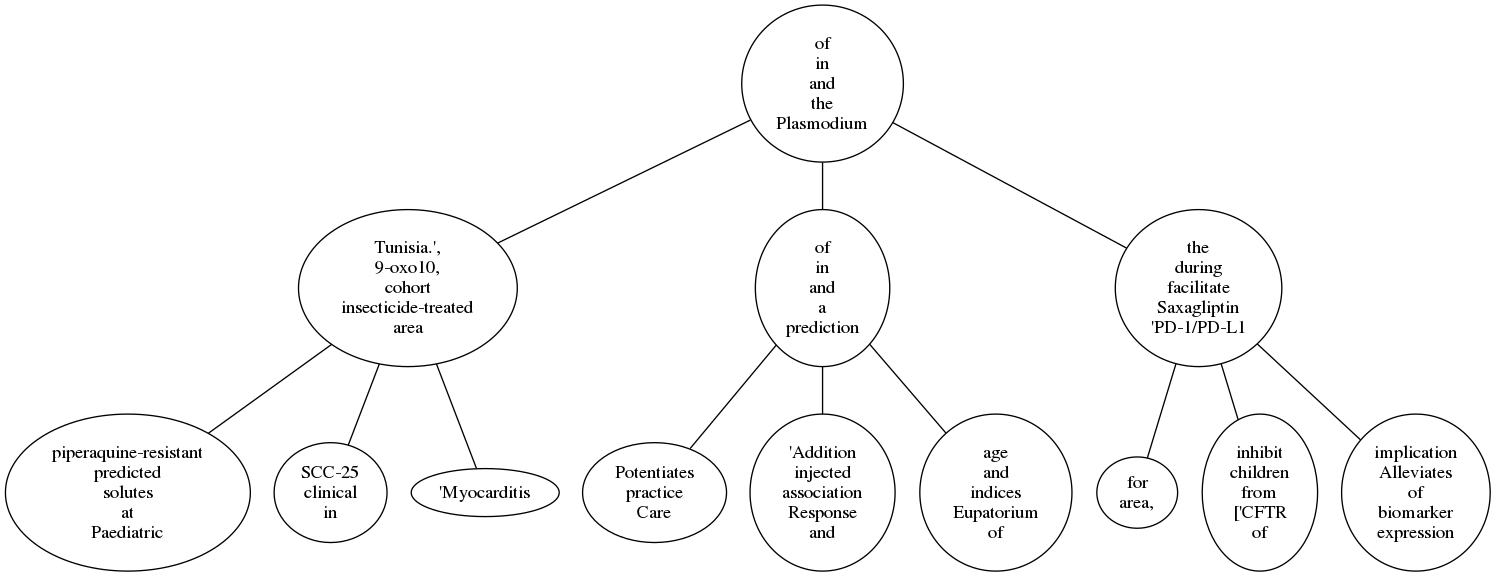

In [76]:
tree_plot(t1, num=5)